# Research Question 3:
## Reducing Dimensionality of our Dataset and Clustering
#### Jameson Carter
#### 12/5/2021
The dataset obtained in 7_CombineData.ipynb has more than 100 variables. This code uses PCA analysis to reduce the dimensionality of our dataset and reduce collinearity, using scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

The purpose of this process is to explore the two components of our third research question:
 - Can we effectively cluster census tracts into groups with similar characteristics (unsupervised learning)?
  - How are these tract clusters delineated?
 - Do census tracts in a given cluster have similar outcomes in terms of use of force complaints?

## Importing Data and Fitting/Tuning Initial K-Means Clustering
To start, I import the data and perform a regular K means clustering process, to see whether PCA is even necessary. I check to see whether there is an optimal K for the entire dataset (except for the non-numeric variables, as these will not be applicable to PCA).

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from yellowbrick.features import RadViz
import geopandas as gpd

In [58]:
# Replace following dataset with the correct filepath
data = pd.read_csv('C:/Users/jacar/OneDrive/Documents/chicago-complaints/data/Combined.csv')
data = data.drop(['geo_id', 'geometry', 'GEOID10'], axis = 1)

y = data['complaint_count']
# Drop the geographic variables because they are not numerical or ordinal
# Via: https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6
X = data.drop(['complaint_count','lakeMI_qmile','river_qmile','Rail_emile','MajorRd_qmile'], axis = 1)

#### An Initial K-Means Cluster Model
The following two plots find ideal K for K-means modeling using Distortion Scores and Calinski Harabasz Scores. The two plots do not agree, as Distortion Scores suggest a K of 5 and Calinski Harabasz suggest a K of 13. I test both to see whether they produce suitable clusters.

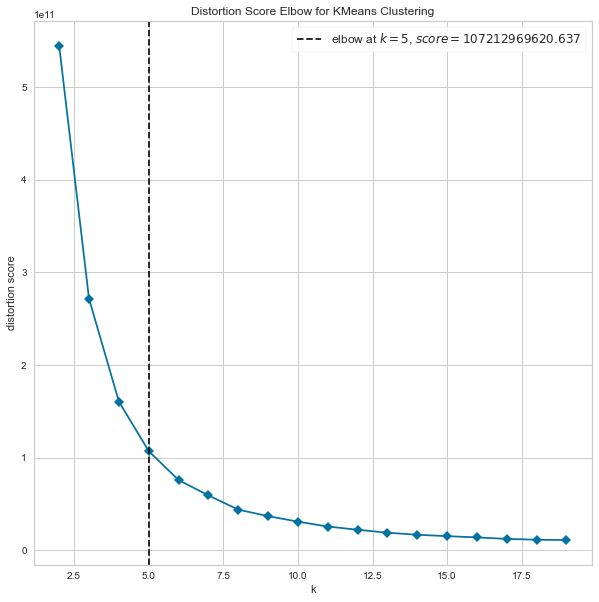

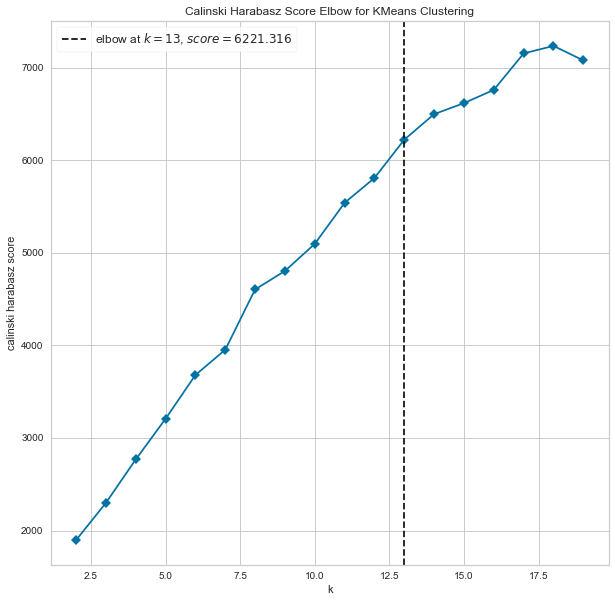

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [59]:
#Create a Kmeans model
model = KMeans(random_state=1)
#run from k=2 to k=20
visualizer = KElbowVisualizer(model, k=(2,20), timings = False)
visualizer.fit(X) # fit elbow visualizer for distortion scores
visualizer.show() # show

visualizer = KElbowVisualizer(model, k=(2,20), metric='calinski_harabasz',locate_elbow=True, timings=False)
visualizer.fit(X) # fit elbow visualizer for CH scores
visualizer.show() # show

#### Initial Model at K = 5
The following finds large variation in cluster size via the silhouette plot, and overlap in the three largest clusters. This does not seem suitable.

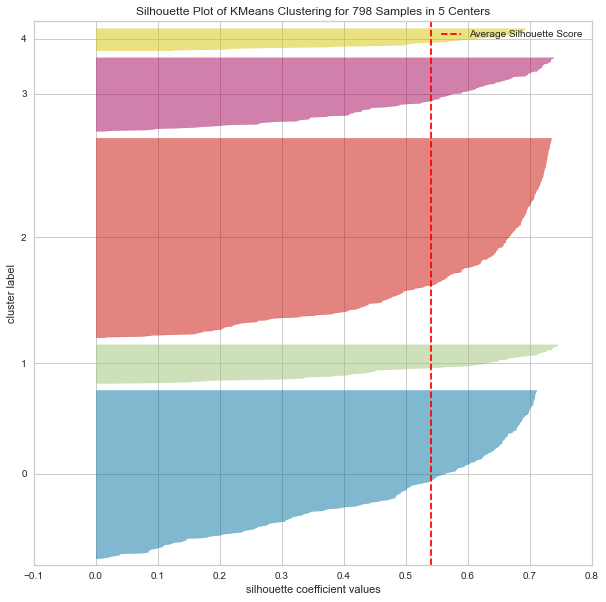

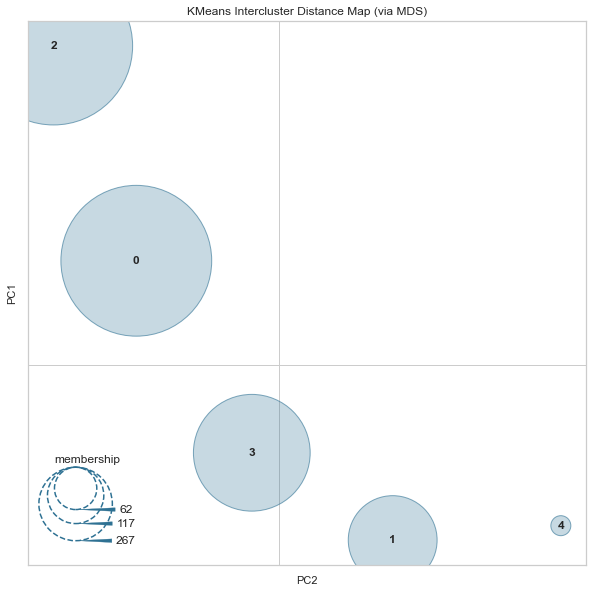

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [60]:
modeldist = KMeans(random_state=1, n_clusters = 5) # initialize a k-means model at k = 5

visualizer = SilhouetteVisualizer(modeldist, colors='yellowbrick') # initialize a silhouette plot 
visualizer.fit(X) # fit silhouette score visualizer
visualizer.show() # show

visualizer = InterclusterDistance(modeldist, colors='yellowbrick') # initialize intercluster distance map
visualizer.fit(X) # fit intercluster distance map visualizer
visualizer.show()  # show

#### Initial Model at K = 13
The following finds large variation in cluster size via the silhouette plot, and overlap among all of the clusters besides one very small cluster in the Intercluster Distance map. This also appears to be a bad clustering method.

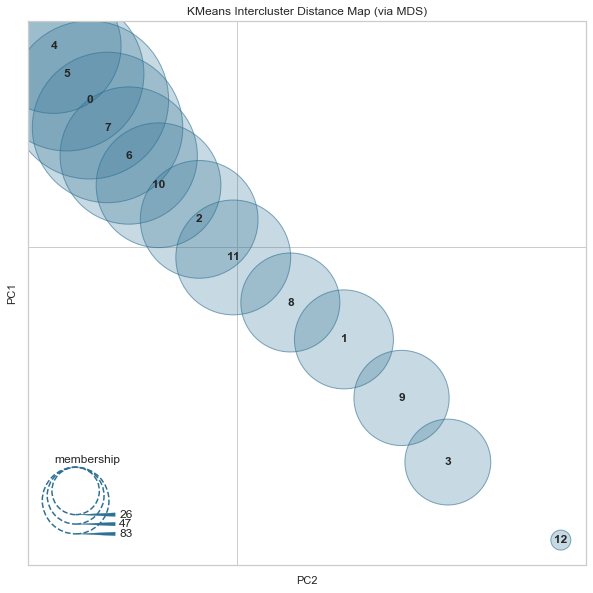

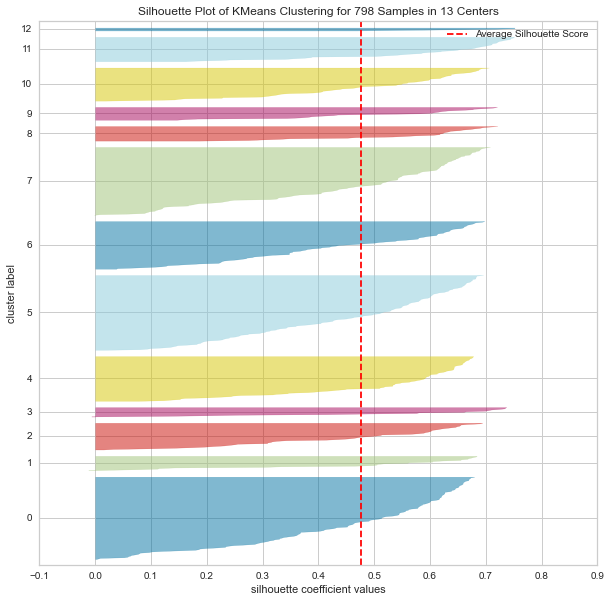

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 798 Samples in 13 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [61]:
modelch = KMeans(random_state=1, n_clusters = 13) # initialize a k-means model at k = 13
visualizer = InterclusterDistance(modelch, colors='yellowbrick') # initialize a silhouette plot 
visualizer.fit(X) # fit silhouette score visualizer
visualizer.show() # show

visualizer = SilhouetteVisualizer(modelch, colors='yellowbrick')# initialize intercluster distance map
visualizer.fit(X) # fit intercluster distance map visualizer
visualizer.show() # show

## Begin PCA Process by Standardizing Relevant Features
It is possible that the overlap in clusters is a function of high dimensionality in the data, among many highly-correlated features, and that therefore this exercise would benefit from a PCA analysis. PCA can reduce noise in the data and produce a reasonable approximation of the data at a lower dimension. This works particularly well if the data, in the presence of high multicollinearity, is *essentially* low in dimension. To come to this point, I used your PCA lecture as well as a series of other sources listed at the bottom of the file. In this section, I standardize data for use in a PCA model and then continue on with further analysis.

In [62]:
scaler = StandardScaler() # initialize standard scaler model
scaledSubs=scaler.fit(X).transform(X) # transform numeric x variables to N ~ (0,1)

In [63]:
print(f'Did standardizing the data to ~N(0,1) work?\n'
      f'Mean is roughly {round(scaledSubs.mean())},\nStdev is exactly {scaledSubs.std()}') # check results of standard scaler

Did standardizing the data to ~N(0,1) work?
Mean is roughly 0,
Stdev is exactly 1.0


### Fitting PCA and tuning ideal number of PCs
In this section, I use the standardized data to determine the optimal number of PCs for this analysis, and fit a PCA model to the scaled data, to obtain dimension-reduced PCAs which account for a sufficient proportion of variance in the dataset.

In [64]:
pca = PCA() # initialize empty PCA model with default components equal to number of features in overall dataset
pca.fit(scaledSubs) # fit PCA to the scaled dataset

PCA()

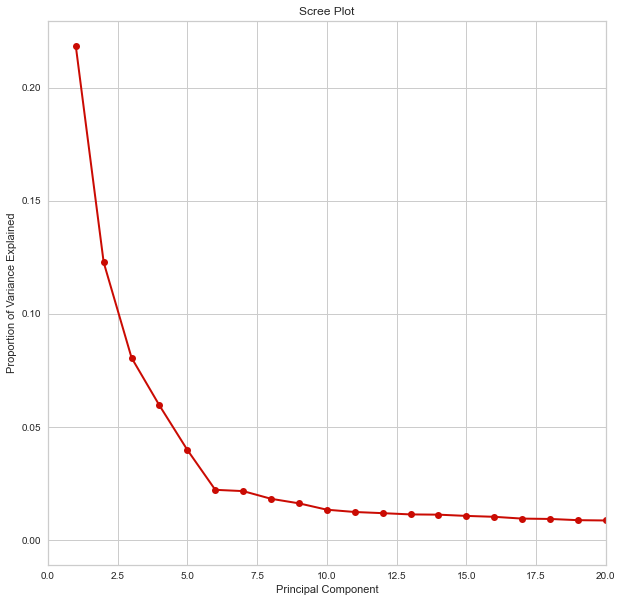

In [65]:
PC_values = np.arange(pca.n_components_) + 1 # obtain list of principal component labels
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2) # plot Scree plot to determine ideal number of PCs
plt.title('Scree Plot') # title
plt.xlabel('Principal Component') # x axis label
plt.ylabel('Proportion of Variance Explained') # y axis label
plt.xlim([0, 20]) # limit the plot to where we can see the elbow point
plt.show()

The above scree plot suggests that we keep 6 principal components, or potentially even more, because the elbow point is observable clearly at 6 PCs, however the slope declines again before leveling off. I will go with 6.

In [66]:
pca = PCA(n_components = 6) # fit pca model to tuned number of components
reduced_data = pca.fit_transform(scaledSubs) # get a reduced form of the data by fitting the scaled data to the PCA

### Tuning K for K-means clustering on dimensionality-reduced data
In this section, I use the reduced data to cluster on K-means, to see what the optimal K-means n should be. We have already tuned the data to an optimal number of principal components, and now need to input those principal components into the K-means model, and tune K.

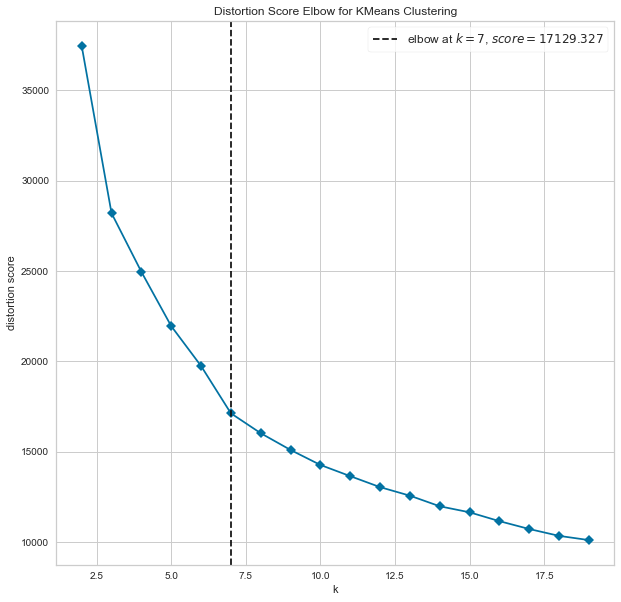

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [67]:
#Create a Kmeans model
model = KMeans(random_state=1)
#run from k=2 to k=20
visualizer = KElbowVisualizer(model, k=(2,20), timings = False) # initialize elbow visualizer for distortion scores
visualizer.fit(reduced_data) # fit elbow visualizer for distortion scores over reduced dataset
visualizer.show()

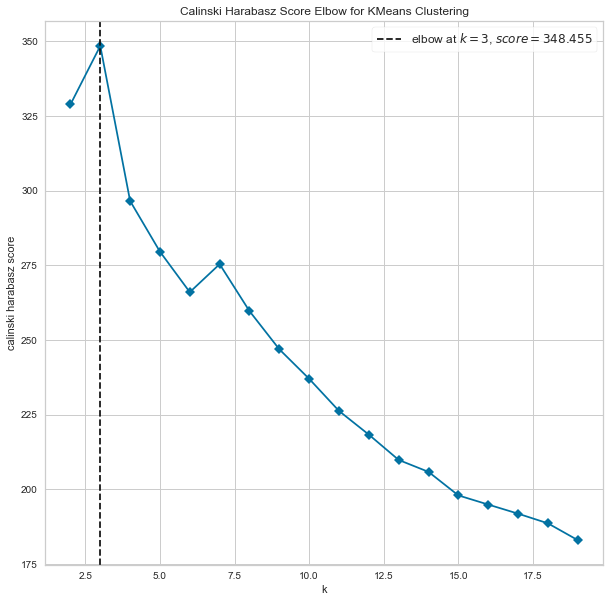

In [68]:
# initialize elbow visualizer for CH scores
visualizer = KElbowVisualizer(model, k=(2,20), metric='calinski_harabasz',locate_elbow=True, timings=False) 
visualizer.fit(reduced_data) # fit elbow visualizer for CH scores over reduced dataset
visualizer.show();

Each plot is giving a different outcome, 3 clusters for Calinski Harabasz Scores and 7 for Distortion Scores. To evaluate further, I will look at the Silhouette plots and Intercluster Distance plots to see which K forms better clusters according to their intercluster distance and silhoeutte scores.

### Evaluating Performance of K = 7
At K = 7, the intercluster distance map shows badly-separated clusters with high overlap, and the silhouette plot shows wide variation in cluster size, though all are above the average silhouette score. Some of these clusters have better silhouette scores that are closer to 1, such as cluster 1, and others have a bunch of observations that may have been clustered incorrectly (such as cluster 6). Next, we will evaluate the same model on K = 3.

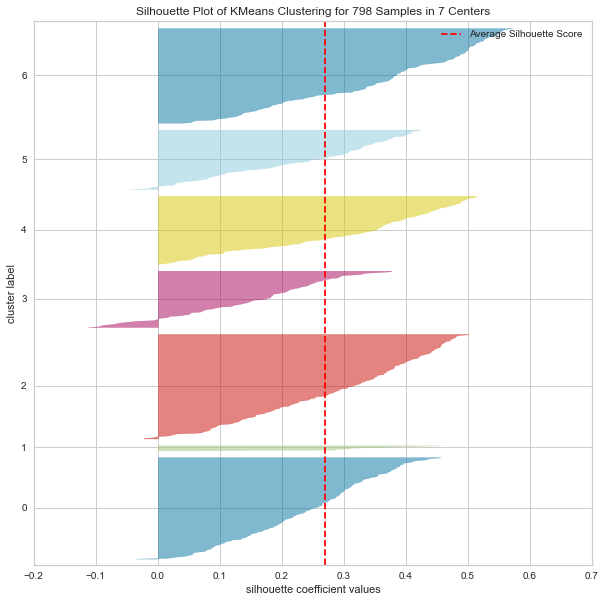

In [69]:
modeldist = KMeans(random_state=1, n_clusters = 7) # initialize a k-means model at k = 7

visualizer = SilhouetteVisualizer(modeldist, colors='yellowbrick') # initialize a silhouette plot
visualizer.fit(reduced_data) # fit visualizer to principal components
visualizer.show();    

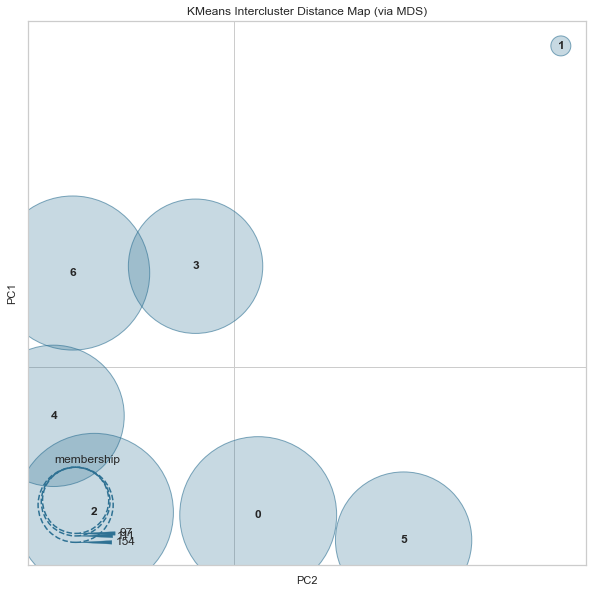

In [70]:
visualizer = InterclusterDistance(modeldist, colors='yellowbrick') # initialize intercluster distance map
visualizer.fit(reduced_data) # fit visualizer to principal components
visualizer.show();    

### Evaluating Performance of K = 3
The intercluster distance map shows well-separated clusters, and the silhouette plot shows similarly sized clusters where all are above the average silhouette score. These scores are not as close to 1 as you might hope, which may be due to a lack of density within the clusters. However, the separation between clusters is quite convincing, per the intercluster distance map. The silhouette plot does appear to show a small number of observations in cluster 0 that may be in the wrong cluster, since they are negative. However this problem is way more pronounced for K = 7. K = 3 appears to be the preferable option.

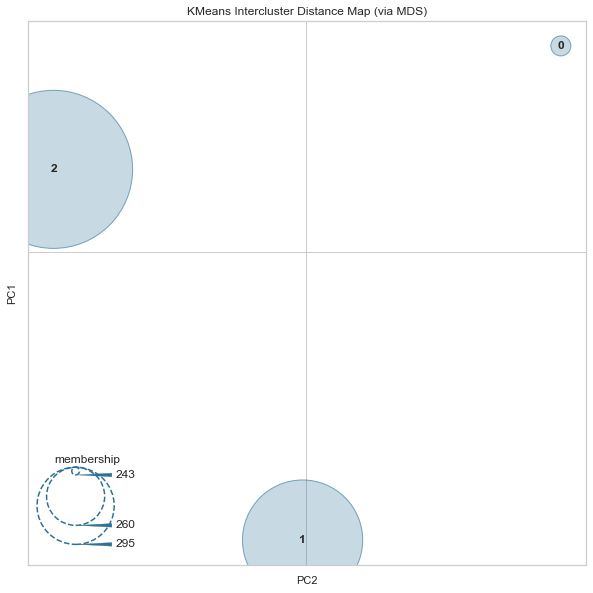

In [71]:
modelch = KMeans(random_state=1, n_clusters = 3) # initialize a k-means model at k = 3
visualizer = InterclusterDistance(modelch, colors='yellowbrick')# initialize intercluster distance map
visualizer.fit(reduced_data) # fit visualizer to principal components
visualizer.show();    

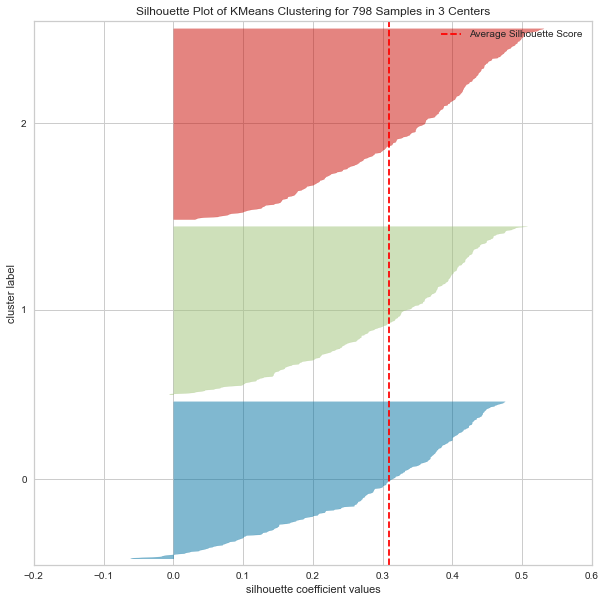

In [72]:
visualizer = SilhouetteVisualizer(modelch, colors='yellowbrick') # initialize a silhouette plot
visualizer.fit(reduced_data) # fit visualizer to principal components
visualizer.show();    

#### Secondary Evaluation: Plotting First Two PCs Against Cluster
It appears that the first two principal components are enough to see the separation in the data, among clusters. There is some overlap, at this dimension, and there appears to be relatively low levels of separation although the clusters are well-formed. Given the results thus far, I select this model, a k-means model with 3 clusters over 6 principal components, as my final model.

In [73]:
data_kmeans = pd.concat([X.reset_index(drop=True), pd.DataFrame(reduced_data)], axis = 1) # attach PCs to original dataset
data_kmeans.columns.values[-6: ] = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'] # assign titles to PCs
data_kmeans['K-Means Cluster'] = modelch.labels_ # assign cluster to each observation

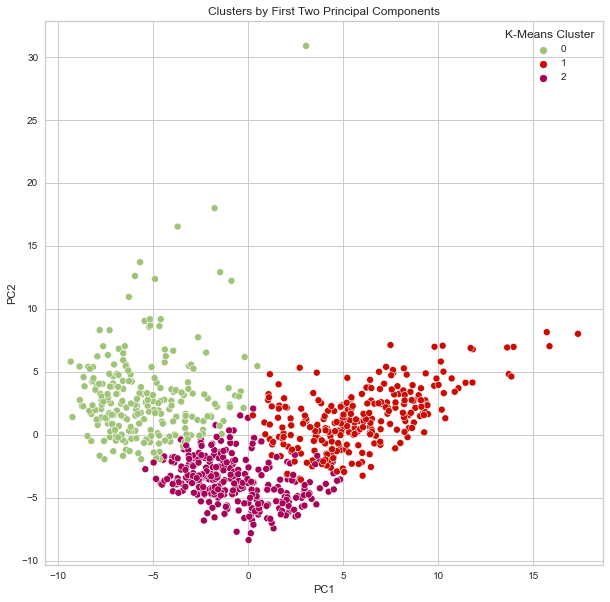

In [74]:
x_axis = data_kmeans['PC1'] # get PC1 and PC2
y_axis = data_kmeans['PC2']
sns.scatterplot(x=x_axis, y=y_axis, hue = data_kmeans['K-Means Cluster'], palette = ['g', 'r', 'm']) # plot PC1 and PC2
plt.title('Clusters by First Two Principal Components') # title
plt.show()

### Examining Results
In this section, I examine the results of the final model: a K-means model at k = 3 as described above, conducted over six principal components.

First, I will examine a few variables of interest by cluster. 


In [75]:
data_kmeans['complaint_count'] = y.copy() # add the y variable back to the dataset

# examine a few variables of interest by cluster!
print('Complaint Count by cluster:\n',data_kmeans.groupby('K-Means Cluster').describe()['complaint_count'])
print('Black population by cluster:\n',data_kmeans.groupby('K-Means Cluster').describe()['DP05_0038PE'])
print('\nPolice stops by cluster:\n', data_kmeans.groupby('K-Means Cluster').describe()['inv_stop_count'])
print('\nPercentage in Poverty by cluster:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP03_0119PE'])
print('\nWeapons Violations by cluster:\n', data_kmeans.groupby('K-Means Cluster').describe()['WEAPONS VIOLATION'])


Complaint Count by cluster:
                  count      mean       std  min  25%  50%  75%   max
K-Means Cluster                                                     
0                243.0  0.576132  1.278140  0.0  0.0  0.0  1.0  11.0
1                260.0  1.288462  1.657282  0.0  0.0  1.0  2.0  12.0
2                295.0  0.583051  1.062207  0.0  0.0  0.0  1.0   8.0
Black population by cluster:
                  count       mean        std   min   25%   50%     75%    max
K-Means Cluster                                                              
0                243.0  12.718930  16.356586   0.0   2.9   5.5  16.900   84.2
1                260.0  88.320385  13.099734  16.2  85.4  92.7  96.525  100.0
2                295.0   9.067458  16.816034   0.0   1.3   3.2   6.700  100.0

Police stops by cluster:
                  count       mean        std  min   25%   50%   75%   max
K-Means Cluster                                                          
0                243.0  36.6913

The above results are retabulated below to highlight medians: many of our census tract variables are percentages that are averaged by the Census Bureau over multiple years, as so we did not want to take the mean, of a mean, across geographic units with different populations. At the median, Cluster 1 tracts experience 1 use-of-force complaint compared to 0 for the other two tracts. Cluster 1 also has a higher Black population, poverty rates, and weapons violations compared to the other clusters. Number of police stops in these clusters is surprisingly low considering the history of Chicago police targeting Black communities (https://blockclubchicago.org/2021/08/31/chicago-police-pull-over-black-drivers-7-times-more-often-than-white-drivers-state-report-shows/), but later analyses find this cluster also has the lowest median population. So it is possible that difference between clusters is hiding the relatively higher rate at which Chicago PD pull over Black drivers. Further, no statistical tests of significant difference have been calculated in this step, as the procedures for conducting statistical difference tests given the Census survey framework is extensive and beyond the scope of this course. Conducting formal difference tests between Census variables, and non-census variables, will be reserved for future research.

| *Variable, measured at tract median*  | Cluster 0 | Cluster 1 | Cluster 2 |
| ----------- |-----------|-----------|-----------|
| Complaint count | 0 | 1 | 0 |
| % Black | 5.5% | 92.7% | 3.2% |
| Police stops | 35 | 32 | 32 |
| % Poor | 4.2% | 25.4% | 11.3% |
| Weapons violations | 4 | 55 | 11 |

These results are interesting, however they do not get at the core of PCA- the loading vectors calculated for each principal component. These vectors, with one value assigned to each feature of the dataset, can be examined to determine which variable was most important in forming the principal component. Next, I evaluate this process.

Evaluating each Principal Component more closely, the five variables that contributed most to each principal component score were:
   - PC1: DP03_0098PE, The percentage of persons with public health insurance
   - PC2: DP02_0016E, The average household size
   - PC3: B01001_001E, The total population of the Census Tract
   - PC4: DP02_0077PE, Civilian noninstitutionalized older age population with a disability
   - PC5: DP02_0093PE, Percentage of Census Tract population born abroad
   - PC6: DP02_0053PE, population 3 or older and enrolled in school
   
This does not imply that other variables were unimportant, just that these had the highest loading vector values within each PC

In [76]:
# absolute value of PCs
pcaframe = abs(pd.DataFrame(pca.components_,columns=X.columns,index = ['PC1','PC2','PC3', 'PC4', 'PC5', 'PC6'])) 
# Find columns with highest absolute contribution to loading vector
print(f'The top most influential variables for each Principal Component were:\n{pcaframe.idxmax(axis = 1)}') 

The top most influential variables for each Principal Component were:
PC1    DP03_0098PE
PC2     DP02_0016E
PC3    B01001_001E
PC4    DP02_0077PE
PC5    DP02_0093PE
PC6    DP02_0053PE
dtype: object


With this result, I create a radial visualizer to examine how each variable played a role in forming each cluster. It appears that cluster 1 is pulled towards the "% with public insurance" variable, as well as the average household size variable, and away from "older diabled adults" and "% born abroad." There is overlap, but the radial plot does reveal some interesting trends nonetheless. There appears to be decent separability between the clusters, according to these 6 particular variables that were important for generating principal components.

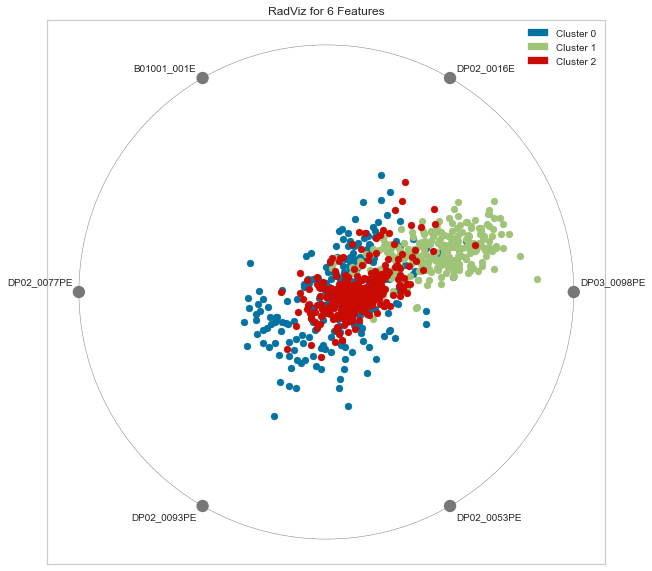

<AxesSubplot:title={'center':'RadViz for 6 Features'}>

In [77]:
PCA_y = data_kmeans['K-Means Cluster'].copy()
PCA_X = data_kmeans[['DP03_0098PE', 'DP02_0016E', 'B01001_001E', 'DP02_0077PE', 'DP02_0093PE', 'DP02_0053PE']].copy()

classes = ["Cluster 0", "Cluster 1", "Cluster 2"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes)
visualizer.fit(PCA_X, PCA_y)
visualizer.transform(PCA_X)  
visualizer.show()    

Finally, I run the same exploratory analysis as before, tabulating these 6 variables by cluster to examine differences.

In [78]:
# Print results!
print('% Persons with Public Health Insurance:\n',data_kmeans.groupby('K-Means Cluster').describe()['DP03_0098PE'])
print('\nAverage household size:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP02_0016E'])
print('\nTotal Population by cluster:\n', data_kmeans.groupby('K-Means Cluster').describe()['B01001_001E'])
print('\nOlder Adults with a Disability:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP02_0077PE'])
print('\n% People Born Abroad:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP02_0093PE'])
print('\n3 and Older Enrolled in School:\n', data_kmeans.groupby('K-Means Cluster').describe()['DP02_0053PE'])


% Persons with Public Health Insurance:
                  count       mean        std   min    25%   50%     75%   max
K-Means Cluster                                                              
0                243.0  19.189712  11.094710   3.6  10.30  17.3  26.000  55.0
1                260.0  58.854615  10.217406  34.6  51.50  58.1  66.375  85.9
2                295.0  37.356610  10.343022  14.9  30.15  37.0  44.050  67.5

Average household size:
                  count      mean       std   min    25%   50%     75%   max
K-Means Cluster                                                            
0                243.0  2.070741  0.372105  1.33  1.725  2.08  2.3750  3.19
1                260.0  2.628231  0.452178  1.35  2.320  2.62  2.9425  3.88
2                295.0  3.025390  0.461942  1.65  2.660  2.99  3.3550  4.35

Total Population by cluster:
                  count         mean          std    min      25%     50%  \
K-Means Cluster                                         

The above results are interesting. Below, I have added the results, at the median, to the earlier table. From this I find that cluster 1, which has the highest median complaints, has higher utilization of public insurance and a higher black population, a smaller population and percentage of foreign-born residents, and fewer school enrolees. Cluster 1 had middling results for number of older adults with a disabilitiy, and for mean hosuehold size as well. These results largely track with the radial visualizer plot from before. 

| *Variable, measured at tract median*  | Cluster 0 | Cluster 1 | Cluster 2 |
| ----------- |-----------|-----------|-----------|
| Complaint count | 0 | 1 | 0 |
| % Black | 5.5% | 92.7% | 3.2% |
| Police stops | 35 | 32 | 32 |
| % Poor | 4.2% | 25.4% | 11.3% |
| % Publicly insured | 17.3% | 58.1% | 37.0% |
| Mean household size | 2.1 | 2.6 | 3 |
| Total population | 2,936 | 2,418 | 4,019 |
| Older adults with disability | 231 | 324 | 465 |
| % Born abroad | 14.9% | 2.6% | 33.0% |
| # School Enrollees | 564 | 351 | 695 |

This leads me to ask, where are these clusters occuring?

#### Plotting Clusters Geographically
The below plot finds that the geographic location of these clusters largely fall along racial lines, tracking closely with the areas of the city with a high Black population. Cluster 1, where complaints at the median are highest, almost entirely encompasses the parts of the city that are black. However, there are members of cluster 1 that do not follow that distinction, seemingly, and tracts that are further away from the main body of the cluster. This is to say that some of these tracts may be more similar to the other clusters, for some reason, than to their neighboring tracts. 

Text(0.5, 1.0, 'Cluster locations in Chicago')

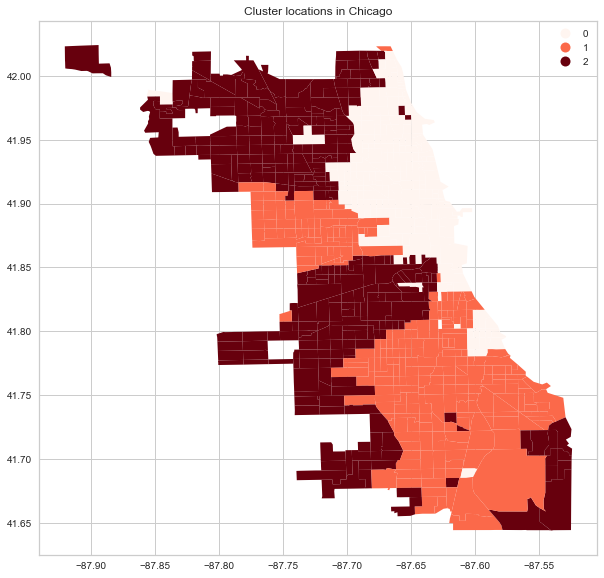

In [79]:
data = pd.read_csv('C:/Users/jacar/OneDrive/Documents/chicago-complaints/data/Combined.csv')
data['K-Means Cluster'] = modelch.labels_

data['geometry'] = gpd.GeoSeries.from_wkt(data['geometry'])
plt.rcParams['figure.figsize'] = [10, 10]
GeoData = gpd.GeoDataFrame(data, geometry='geometry')
GeoData.plot(column = "K-Means Cluster", categorical = True, cmap = "Reds", legend = True)
plt.title('Cluster locations in Chicago')

### Suggestions for Policymakers and Synthesized Findings
This section of our research project aimed to touch on the questions:
 - Can we effectively cluster census tracts into groups with similar characteristics (unsupervised learning)?
  - How are these tract clusters delineated?
 - Do census tracts in a given cluster have similar outcomes in terms of use of force complaints?
 
And to answer these questions in the framework of policy change.

This exploration answers our original research questions more concretely with the following findings:
 - We *can* effectively cluster tracts into groups with similar characteristics, and those groups are likely delineated along the following demographic lines:
     - Race
     - % Born abroad, % with public insurance, % in poverty
     - Population of school enrollees, older adults with disabilities, and total population
     - Household size
 - Census tracts in a given cluster *seem* to have *differing* outcomes in terms of use of force complaints:
     - Cluster 1, distinctly characterized by a relatively high Black population, relatively low foreign-born population, high poverty, high public insurance rates, and low school enrollment experiences the highest use-of-force complaints at the median
     
Given the above explorations, I think that policymakers should examine more closely the relationships between areas of the city with more Black residents and the Chicago police. Further, it could be of interest to sociologically explore the intersections between public health (this cluster has high rates of public insurance and numbers of disabled adults), education justice (the cluster has fewer kids in school), and poverty with use of force complaints.


### Future Work
Future researchers should examine more rigorous statistical difference testing in determining whether clusters significantly differ from one another, and namely whether the number of complaints in Cluster 1 are statistically different from the observations in other clusters. Further, a deeper evaluation of the principal components resulting from the final clustering model should be examined- it is possible that some interesting variables were the second, or third most important in a given loading vector. In this piece I have only examined the top most important variables. Additionally, the tracts which do not follow the broader geographic trends exhibited here should be examined in further depth. For example, some tracts that exhibited a relatively high Black population did not fall into Cluster 1. I wonder whether those tracts had lower incidence of public insurance or high rates of foreign-born residents, variables which were important to forming the PCs.

Finally, I will reiterate the previous point that it would be worth studying the region defined in Cluster 1 in more detail, particularly the region's relationships with the Chicago Police. Our investigatory stops data is reported by the Chicago Police, for example, which may be subject to biases that would not be captured in a quantitative setting. Additionally, our complaint data could be subject to reporting errors. It could be the case that communities which experience higher use of force trust the system to resolve their complaints, and therefore they do not submit a complaint. So it might be useful for future researchers to examine whether the region defined in cluster 1 is experiencing such a reporting bias.

## References

 - https://stackoverflow.com/questions/32860849/classification-pca-and-logistic-regression-using-sklearn
 - My in-class exercise on clustering: Clustering-Mini2_JamesonCarter
 - https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
 - https://365datascience.com/tutorials/python-tutorials/pca-k-means/
 - https://dl.acm.org/doi/10.1145/1015330.1015408
 - https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
 - https://medium.com/swlh/k-means-clustering-on-high-dimensional-data-d2151e1a4240
